In [1]:
source("./polyjit.R")
library(RPostgres)

con <- dbConnect(RPostgres::Postgres(),
                 dbname="pprof",
                 user="pprof",
                 host="debussy.fim.uni-passau.de",
                 port=32768,
                 password="pprof")
get_experiments(connection = con)

Package 'sm', version 2.2-5.4: type help(sm) for summary information
Warning message:
In result_create(conn@ptr, statement): Unknown field type (2950) in column experiment_group

,experiment_group,experiment_name,completed
1,5097fb17-13d1-47cf-88d7-3edb02e91609,polyjit,2015-09-14 11:32:04.408278
2,9684ad5d-f85c-48bf-ba14-e9fcbcb69818,raw,2015-09-15 01:11:55.106435
3,b19b8633-2f59-4e14-a8e5-d476f17671ed,polyjit,2015-09-15 11:08:38.415339


In [4]:
library(ggplot2)
options(repr.plot.family = 'mono', repr.plot.width = 10, repr.plot.height = 10, warn = -1)

In [36]:
timings <- "

SELECT spd.project_name, spd.cores, spd.ptime, spd.time, spd.speedup,
    CASE WHEN spd.speedup >= 1 OR spd.speedup = 0 THEN spd.speedup
         WHEN spd.speedup > 0 AND spd.speedup < 1 THEN -1/spd.speedup
    END as speedup_corrected
FROM
    (
        SELECT pjit.project_name, pjit.cval as cores,  pjit.sum as ptime, raw.sum as time,
               (raw.sum / pjit.sum) as speedup
        FROM
            (
                select project_name, metrics.name, SUM(metrics.value), config.name, cast ( config.value as INTEGER) as cval from run, metrics, config
                where (experiment_name = 'polyjit') and run.id = metrics.run_id and run.id = config.run_id and metrics.name = 'time.real_s'
                group by project_name, metrics.name, config.name, cval
                order by project_name, cval
            ) as pjit,
            (
                select project_name, metrics.name, SUM(metrics.value), config.name, cast ( config.value as INTEGER) as cval from run, metrics, config
                where (experiment_name = 'raw') and run.id = metrics.run_id and run.id = config.run_id and metrics.name = 'time.real_s'
                group by project_name, metrics.name, config.name, cval
                order by project_name, cval
            ) as raw
        WHERE pjit.project_name = raw.project_name
        ORDER BY cores ASC
    ) as spd, project
WHERE spd.project_name = project.name AND project.group_name <> 'polybench' AND project.name IN ('bzip2', 'python', 'lulesh')
;
"

qr.timings <- dbSendQuery(con, timings)
res.timings <- dbFetch(qr.timings)
dbClearResult(qr.timings)

[1] TRUE

In [37]:
head(res.timings)
nrow(res.timings)

,project_name,cores,ptime,time,speedup,speedup_corrected
1,bzip2,1,6.51,5.79,0.8894009,-1.124352
2,python,1,2.42,0.75,0.3099174,-3.226667
3,lulesh,1,59.96,1.09,0.01817879,-55.00917
4,python,2,2.42,0.75,0.3099174,-3.226667
5,bzip2,2,6.52,5.79,0.8880368,-1.126079
6,lulesh,2,59.16,1.09,0.01842461,-54.27523


[1] 57

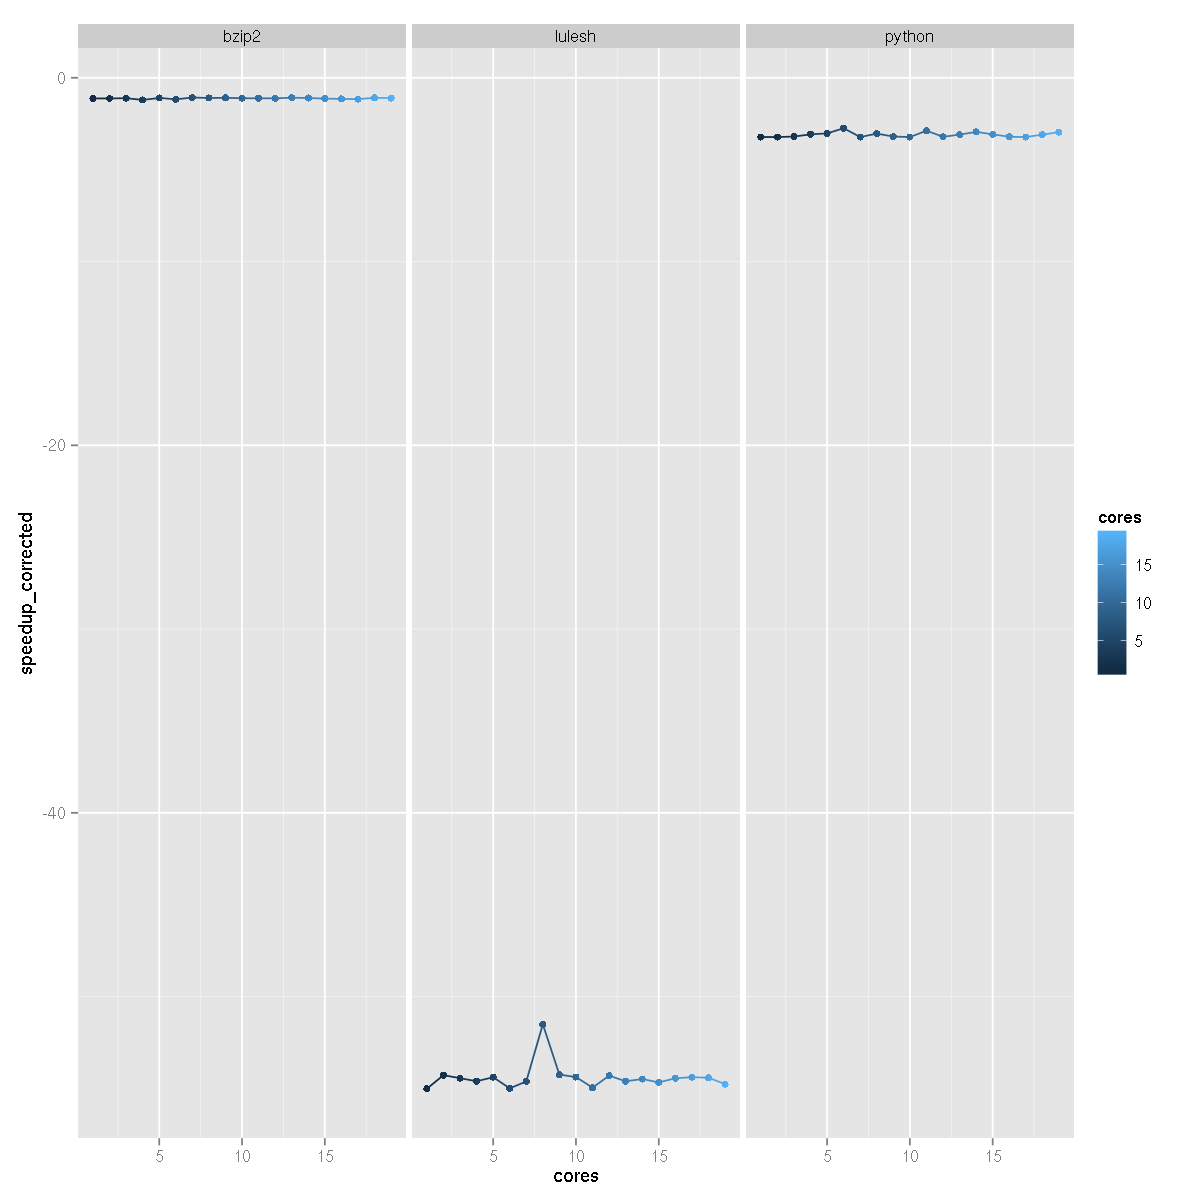

In [38]:
ggplot(data=res.timings,
       aes(x = cores, y = speedup_corrected, fill = cores, color = cores)) +
    geom_point(aes(color = cores)) +
    geom_line() +
    #geom_bar(stat="identity", position = "dodge") +
    #scale_y_continuous(limits = c(-20,20), breaks = c(-20,-15,-10,-5,-4,-3,-2,-1,0,1,2,3,4,5,10,15,20)) +
    facet_wrap(~ project_name, ncol = 4)

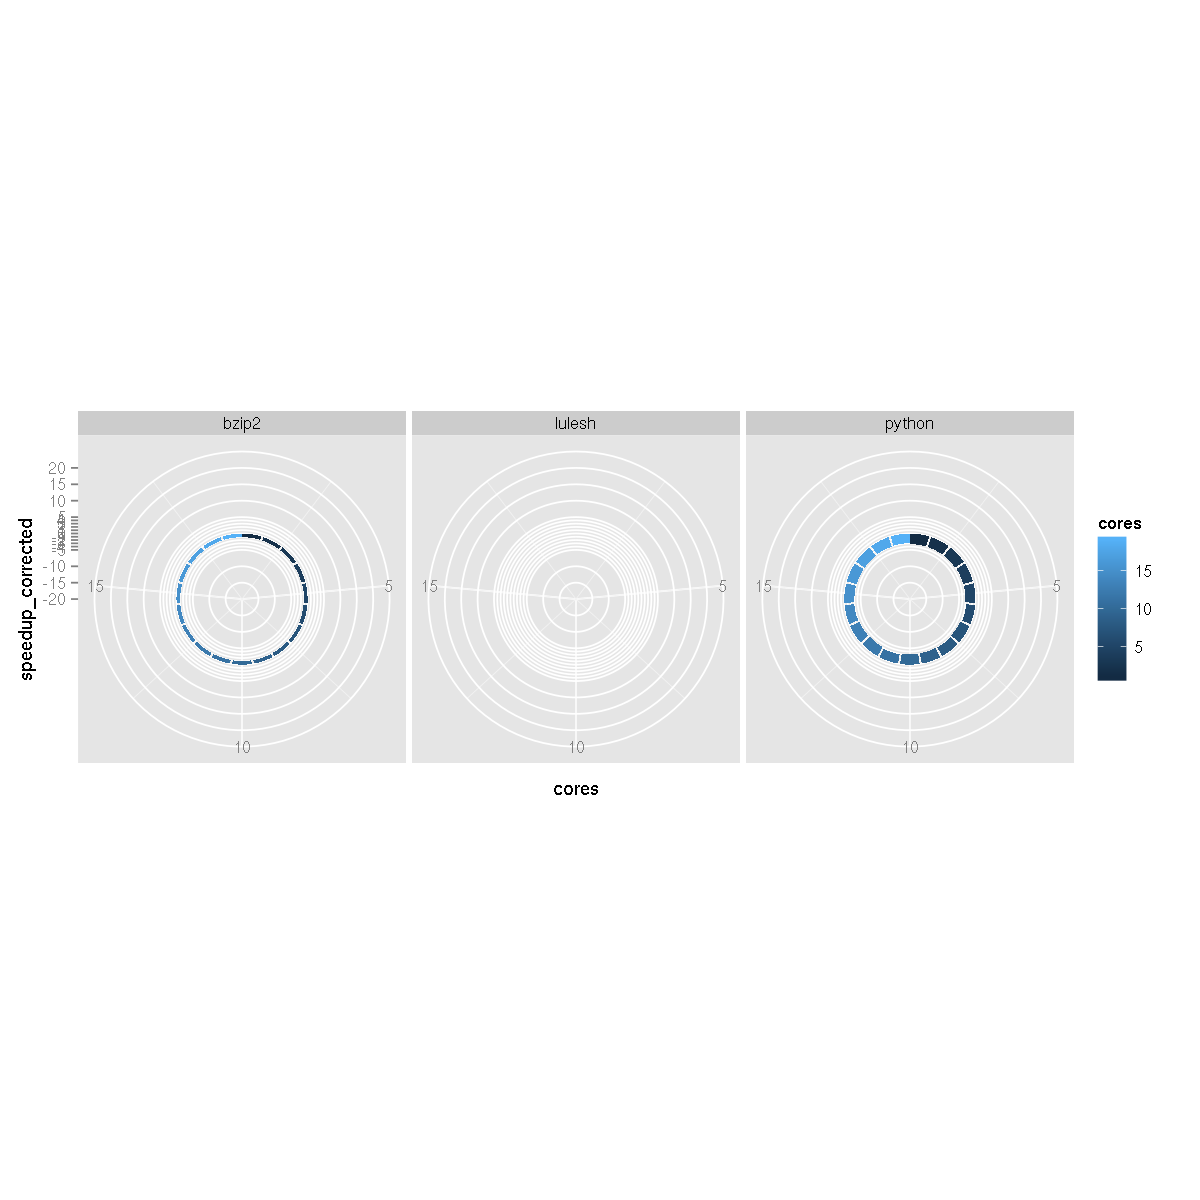

In [39]:
ggplot(data=res.timings,
       aes(x = cores, y = speedup_corrected, fill = cores)) +
    geom_bar(stat="identity", position = "dodge") +
    scale_y_continuous(limits = c(-20,20), breaks = c(-20,-15,-10,-5,-4,-3,-2,-1,0,1,2,3,4,5,10,15,20)) +
    coord_polar() +
    facet_wrap(~ project_name)
    